In [1]:
%%javascript
IPython.OutputArea.auto_scroll_threshold = 9999;

<IPython.core.display.Javascript object>

In [ ]:
# imports
import h5py
from functions import neuron_reliability, reliability_filtering, regression_indices, model_reliability_2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.linear_model import Ridge, RidgeCV
from scipy.stats import sem, pearsonr, ttest_rel, zscore


In [2]:
# import data file
file = h5py.File('230801.pico.rsvp.gratingsAdap_s5.experiment_psth_raw.h5','r')

In [ ]:
# neural data load
rates = file['/psth'][:]
print(rates.shape)
n_img = 40
n_trial = 36 # repetitions
n_bins = 30 # time bins of 10 ms length each (i.e., whole thing is 300 ms)
n_neurons = 192

(40, 36, 30, 192)


In [ ]:
# position data load - the label that we are trying to predict
df = pd.read_csv('season5_meta_reversed.csv') # position data
pos = df['xpos'].values.reshape(-1,1) # get x position data
pos = np.squeeze(pos)

In [6]:
print(f'mean:{np.nanmean(pos):.2f}')
print(f'sd:{np.nanstd(pos):.2f}')
print(f'max:{max(pos):.2f}')
print(f'min:{min(pos):.2f}')

mean:-0.03
sd:0.25
max:0.54
min:-0.55


Text(0.5, 0, 'x position')

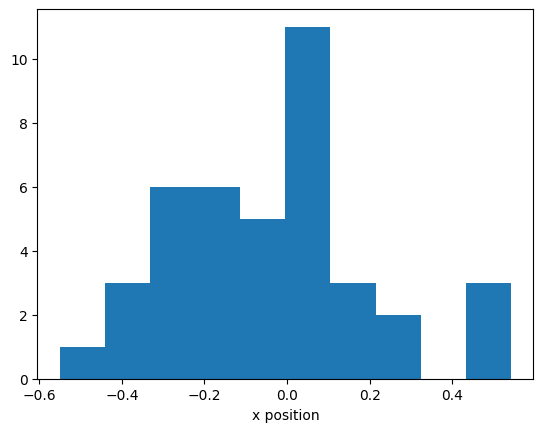

In [7]:
plt.hist(np.squeeze(pos))
plt.xlabel('x position')

In [ ]:
# getting 70-170 ms for S5
s5_neural = np.transpose(np.nanmean(rates[:,:,7:17,:],axis=2), (0,2,1)) # gets the neural data for 70-170 ms only, raised a mean of an empty slice warning bc last couple of reps are empty

/var/folders/5z/s6ntwspd34j0qjt24p80qp_80000gn/T/ipykernel_4669/3531158851.py:2: RuntimeWarning: Mean of empty slice
  s5_neural = np.transpose(np.nanmean(rates[:,:,7:17,:],axis=2), (0,2,1)) # gets the neural data for 70-170 ms only, raised a mean of an empty slice warning, will see if problematic


In [6]:
# get the neuron reliabilities for 70-170 ms
rel, std_rel = neuron_reliability(s5_neural)

Text(0, 0.5, 'pearson r')

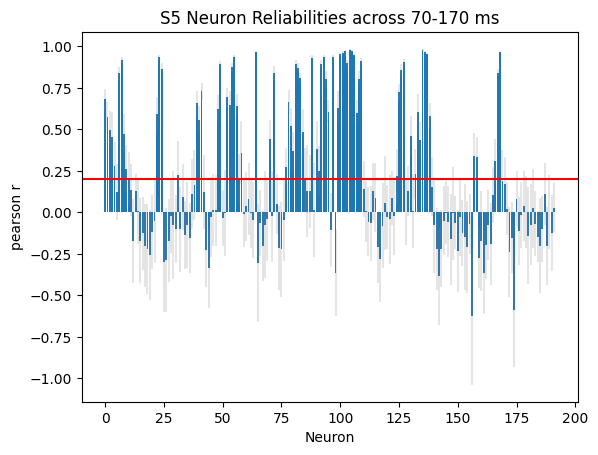

In [7]:
# plot the neuron reliabilities
plt.bar(range(192),rel,yerr=std_rel, error_kw=dict(ecolor='grey',alpha=0.2))
plt.axhline(y=0.2,color='r')
plt.title('S5 Neuron Reliabilities across 70-170 ms')
plt.xlabel('Neuron')
plt.ylabel('pearson r')

In [8]:
# filter neurons to include only those with r > 0.2
s5_neural = reliability_filtering(s5_neural,rel,metric=0.2)

In [8]:
s5_neural.shape

(40, 72, 36)

In [9]:
# normalize the results across units (axis = 1)
s5_neural = zscore(s5_neural, axis=1)

In [14]:
s5_neural.shape

(40, 72, 36)

In [ ]:
# reduce dimensionality for making preds, no more repetitions
s5_neural_for_preds = np.nanmean(s5_neural,axis=2)

In [16]:
s5_neural_for_preds.shape

(40, 72)

In [ ]:
# train the regressor on s5 data (corrected and avoids referencing)
n_reps = 36 # can be any number, i recommend 100 and then you can find the best one
n_folds = 4
alpha_values = [0.01, 0.1, 1, 10, 100]
s5_regressors = {}
s5_reg_rels = np.empty((n_reps,n_folds))
s5_em_array= np.empty((n_img,n_reps)) # 40 images by 36 predictions per image
for x in range(n_reps):
    for i in range(n_folds):
        train, test = regression_indices(n_img, number_of_groups=4, test_group=i, SEED=x)
        x_train = s5_neural_for_preds[train,:]
        y_train = pos[train]
        x_test = s5_neural_for_preds[test,:]
        ridge_cv = RidgeCV(alphas=alpha_values).fit(x_train,y_train) # performs leave-one-out cross validated alpha optimization
        best_alpha = ridge_cv.alpha_
        s5_regressors[f"reg_{x}_{i}"] = Ridge(alpha=best_alpha)
        s5_regressors[f"reg_{x}_{i}"].fit(x_train,y_train)
        y_pred = s5_regressors[f"reg_{x}_{i}"].predict(x_test)
        s5_em_array[test, x] = np.squeeze(y_pred)
        s5_reg_rels[x,i] = model_reliability_2(neural_data=s5_neural, regressor=s5_regressors[f"reg_{x}_{i}"], test_idx=test)
s5_preds = np.nanmean(s5_em_array, axis=1)
s5_preds_sem = sem(s5_em_array, axis=1) 
s5_reg_rels_avg = np.nanmean(s5_reg_rels,axis=1)
corr = np.empty(n_reps) 
for p in range(n_reps):
    corr_temp = pearsonr(np.squeeze(pos), s5_em_array[:,p])[0]
    corr[p] = corr_temp/np.sqrt(s5_reg_rels_avg[p])
s5_corr = np.nanmean(corr)
s5_corr_sem = sem(corr)

average correlation: 0.42 +/- 0.02


<Figure size 600x600 with 0 Axes>

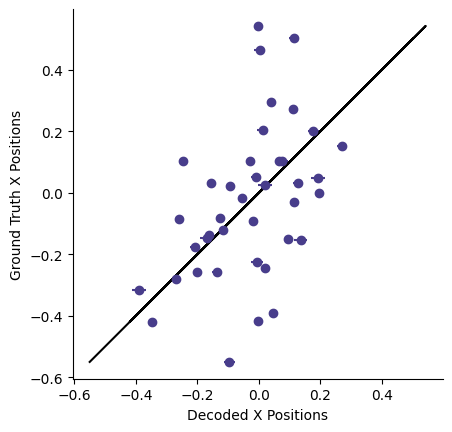

In [12]:
# plot the results for training and testing on S5
print(f'average correlation: {s5_corr:.2f} +/- {s5_corr_sem:.2f}')
# print(f'correlation betweem average prediction and gt: {scipy.stats.pearsonr(np.squeeze(pos), s5_preds)[0]:.2f}')


plt.figure(figsize= (6, 6)) # to ensure that the plot is a square
plt.figure().set_facecolor("white")
plt.gca().set_facecolor("white")
plt.gca().tick_params(colors = "black")
plt.gca().spines['bottom'].set_color('black')
plt.gca().spines['left'].set_color('black')
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.errorbar (s5_preds, pos, yerr=None, xerr=s5_preds_sem, fmt= 'o', color='darkslateblue', ecolor= 'darkslateblue')
plt.plot(pos, pos, color='black')
# plt.title('gt and S5 decodes - 70-170 ms')
plt.xlabel('Decoded X Positions', color = "black")
plt.ylabel('Ground Truth X Positions', color = "black")
# data_min = min(min(s5_preds), min(pos)) # find the smallest value in the data
# data_max = max(max(s5_preds), max(pos)) # find the largest value in the data 
# buffer = 0.05# the amount of space to add to ensure that the data doesn't sit on the axis
# plt.xlim(data_min - buffer, data_max + buffer) # set the x-axis limits to be from the smallest to the largest value
# plt.ylim(data_min - buffer, data_max + buffer) # do the same with the y-axis limits to ensure that the plot has same range and is square

x0,x1 = plt.gca().get_xlim()
y0,y1 = plt.gca().get_ylim()

plt.gca().set_aspect(abs(x1-x0)/abs(y1-y0))

plt.show()

In [13]:
#load and format S1-4
file_s1 = h5py.File('230801.pico.rsvp.gratingsAdap_s1.experiment_psth_raw.h5','r')
file_s2 = h5py.File('230801.pico.rsvp.gratingsAdap_s2.experiment_psth_raw.h5','r')
file_s3 = h5py.File('230801.pico.rsvp.gratingsAdap_s3.experiment_psth_raw.h5','r')
file_s4 = h5py.File('230801.pico.rsvp.gratingsAdap_s4.experiment_psth_raw.h5','r')

rates_s1 = file_s1['/psth'][:]
rates_s2 = file_s2['/psth'][:]
rates_s3 = file_s3['/psth'][:]
rates_s4 = file_s4['/psth'][:]


In [14]:
# getting 70-170 ms for S1-4
s1_neural = np.transpose(np.nanmean(rates_s1[:,:,337:347,:],axis=2), (0,2,1)) 
s2_neural = np.transpose(np.nanmean(rates_s2[:,:,337:347,:],axis=2), (0,2,1)) 
s3_neural = np.transpose(np.nanmean(rates_s3[:,:,337:347,:],axis=2), (0,2,1)) 
s4_neural = np.transpose(np.nanmean(rates_s4[:,:,337:347,:],axis=2), (0,2,1)) 

In [15]:
# filtering such that only neurons with r > 0.2 are left for S1-4
s1_neural = reliability_filtering(s1_neural,rel,metric=0.2)
s2_neural = reliability_filtering(s2_neural,rel,metric=0.2)
s3_neural = reliability_filtering(s3_neural,rel,metric=0.2)
s4_neural = reliability_filtering(s4_neural,rel,metric=0.2)

In [16]:
# z-scoring across units 
s1_neural = zscore(s1_neural, axis=1)
s2_neural = zscore(s2_neural, axis=1)
s3_neural = zscore(s3_neural, axis=1)
s4_neural = zscore(s4_neural, axis=1)

In [17]:
# preparing the data for making predictions
s1_neural_for_preds = np.nanmean(s1_neural,axis=2)
s2_neural_for_preds = np.nanmean(s2_neural,axis=2)
s3_neural_for_preds = np.nanmean(s3_neural,axis=2)
s4_neural_for_preds = np.nanmean(s4_neural,axis=2)

In [18]:
# function for making predictions (corrected, avoids referencing, no double dipping)
def seasons_preds(season_rates):
    em_array= np.empty((n_img,n_reps))
    for x in range(n_reps):
        for i in range(n_folds):
            test = regression_indices(n_img, number_of_groups=n_folds, test_group= i, SEED= x)[1] # use the function in functions.ipynb to get the indices (i.e., the identifier of the images) in the train and test set
            X_test = season_rates[test,:] # index the neural data for the images used for testing from the neural variable
            y_pred = s5_regressors[f"reg_{x}_{i}"].predict(X_test)
            em_array[test,x] = np.squeeze(y_pred)
    s_preds = np.nanmean(em_array, axis=1)
    s_preds_sem = sem(em_array, axis=1)
    corr = np.empty(n_reps) 
    for p in range(n_reps):
        corr_temp = pearsonr(np.squeeze(pos), em_array[:,p])[0] # correlate the predictions from each shuffle with gt
        corr[p] = corr_temp/np.sqrt(s5_reg_rels_avg[p])
    s_corr = np.nanmean(corr)
    s_corr_sem = sem(corr)
    return s_preds, s_preds_sem, s_corr, s_corr_sem, em_array

In [19]:
# getting the predictions for each season
s1_preds, s1_preds_sem, s1_corr, s1_corr_sem, s1_pred_array = seasons_preds(s1_neural_for_preds)
s2_preds, s2_preds_sem, s2_corr, s2_corr_sem, s2_pred_array = seasons_preds(s2_neural_for_preds)
s3_preds, s3_preds_sem, s3_corr, s3_corr_sem, s3_pred_array = seasons_preds(s3_neural_for_preds)
s4_preds, s4_preds_sem, s4_corr, s4_corr_sem, s4_pred_array = seasons_preds(s4_neural_for_preds)

In [20]:
# plotting range
pos_range = np.linspace(min(pos),max(pos))

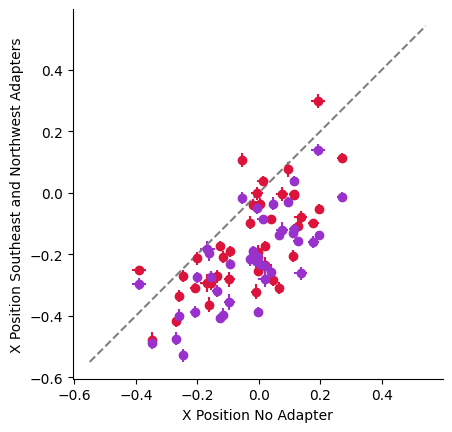

In [32]:
# s1 vs s2 predictions
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

plt.errorbar(s5_preds,s1_preds,xerr=s5_preds_sem,yerr=s1_preds_sem, fmt='o', color='crimson', label = 'Southeast Adapter')
plt.errorbar(s5_preds,s2_preds,xerr=s5_preds_sem,yerr=s2_preds_sem, fmt='o', color='darkorchid', label = 'Northwest Adapter')
plt.plot(pos_range,pos_range, color='grey', linestyle='--')
# plt.xlim(-0.3,0.5)
# plt.ylim(-0.3,0.5)
plt.xlabel('X Position No Adapter', color = "black")
plt.ylabel('X Position Southeast and Northwest Adapters', color = "black")
# plt.title('per image differences s1 (southeast) vs s2 (northwest)')
# plt.legend()

x0,x1 = plt.gca().get_xlim()
y0,y1 = plt.gca().get_ylim()

plt.gca().set_aspect(abs(x1-x0)/abs(y1-y0))

# plt.savefig('x_s12.eps', format='eps', bbox_inches='tight')

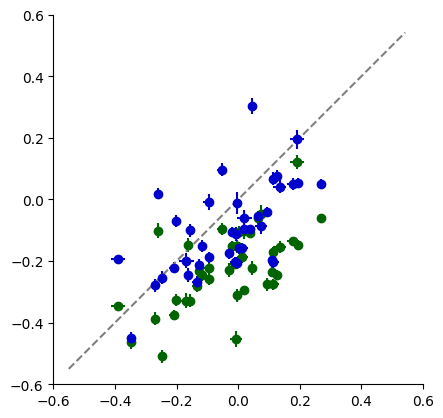

In [22]:
# s3 vs s4 predictions
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

plt.errorbar(s5_preds,s3_preds,xerr=s5_preds_sem,yerr=s3_preds_sem, fmt='o', color='darkgreen', label = 'East Adapter')
plt.errorbar(s5_preds,s4_preds,xerr=s5_preds_sem,yerr=s4_preds_sem, fmt='o', color='mediumblue', label = 'West Adapter')
plt.plot(pos_range,pos_range, color='grey', linestyle='--')
plt.xlim(-0.6,0.6)
plt.ylim(-0.6,0.6)
# plt.xlabel('X Position No Adapter', color = "black")
# plt.ylabel('X Position East and West Adapters', color = "black")

# plt.legend()

x0,x1 = plt.gca().get_xlim()
y0,y1 = plt.gca().get_ylim()

plt.gca().set_aspect(abs(x1-x0)/abs(y1-y0))

plt.savefig('x_s34.eps', format='eps', bbox_inches='tight')

In [20]:
#t-test S4 vs S3
ttest_rel(s4_preds, s3_preds)

TtestResult(statistic=6.197306899449597, pvalue=2.7555610112776857e-07, df=39)

In [21]:
# ttest S4 vs S5
ttest_rel(s4_preds, s5_preds)

TtestResult(statistic=-3.032137347886602, pvalue=0.004301740264671906, df=39)

In [22]:
# ttest S3 vs S5
ttest_rel(s3_preds, s5_preds)

TtestResult(statistic=-9.430677163084663, pvalue=1.310200498572802e-11, df=39)

Below is old stuff that is not very important

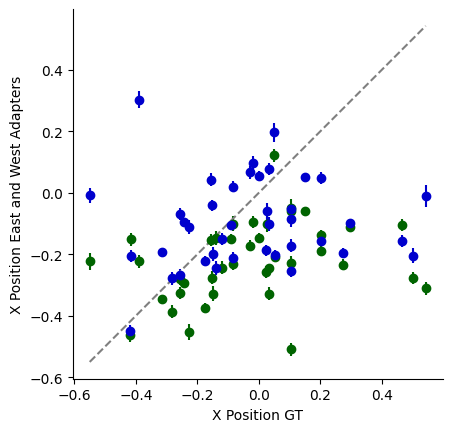

In [26]:
# s3 vs s4 predictions
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

plt.errorbar(pos,s3_preds,xerr=None,yerr=s3_preds_sem, fmt='o', color='darkgreen', label = 'East Adapter')
plt.errorbar(pos,s4_preds,xerr=None,yerr=s4_preds_sem, fmt='o', color='mediumblue', label = 'West Adapter')
plt.plot(pos_range,pos_range, color='grey', linestyle='--')
# plt.xlim(-0.3,0.5)
# plt.ylim(-0.3,0.5)
plt.xlabel('X Position GT', color = "black")
plt.ylabel('X Position East and West Adapters', color = "black")

# plt.legend()

x0,x1 = plt.gca().get_xlim()
y0,y1 = plt.gca().get_ylim()

plt.gca().set_aspect(abs(x1-x0)/abs(y1-y0))

# plt.savefig('x_s34.eps', format='eps', bbox_inches='tight')

In [23]:
# s4 vs gt
ttest_rel(s4_preds, pos)

TtestResult(statistic=-1.4489698661607153, pvalue=0.1553395287882391, df=39)

In [25]:
# S3 vs gt
ttest_rel(s3_preds, pos)

TtestResult(statistic=-4.899803621793944, pvalue=1.717313107157717e-05, df=39)

In [23]:
# initializing empty arrays and repetition for hypothesis testing
n_runs = 100
n_neurons = 72 # the neurons here are features 
n_images = 40

In [24]:
# S1 vs S2 null (no double dipping)
s1_s2_null_avg_delta_dis = np.empty(n_runs)
null_s1 = np.empty((n_images,n_neurons))
null_s2 = np.empty((n_images,n_neurons))
for r in range(n_runs):
    np.random.seed(r)
    shuffle_index = np.random.choice(n_neurons, size=n_neurons, replace=False)
    null_s1[:,shuffle_index[0:int(n_neurons/2)]] = s1_neural_for_preds[:,shuffle_index[0:int(n_neurons/2)]]
    null_s2[:,shuffle_index[int(n_neurons/2):int(n_neurons)]] = s1_neural_for_preds[:,shuffle_index[int(n_neurons/2):int(n_neurons)]]
    null_s2[:,shuffle_index[0:int(n_neurons/2)]] = s2_neural_for_preds[:,shuffle_index[0:int(n_neurons/2)]]
    null_s1[:,shuffle_index[int(n_neurons/2):int(n_neurons)]] = s2_neural_for_preds[:,shuffle_index[int(n_neurons/2):int(n_neurons)]]
    delta_store = np.empty((n_images,n_reps))
    for x in range(n_reps):
        for i in range(n_folds):
            train, test = regression_indices(len(pos), number_of_groups=n_folds, test_group= i, SEED= x)
            y_pred_null_s1 = s5_regressors[f"reg_{x}_{i}"].predict(null_s1[test,:]) # ensuring that each regressor is predicting only the held out images
            y_pred_null_s2 = s5_regressors[f"reg_{x}_{i}"].predict(null_s2[test,:])
            delta_store[test,x]= np.nanmean(y_pred_null_s2 - y_pred_null_s1)
    s1_s2_null_avg_delta_dis[r]= np.nanmean(np.nanmean(delta_store,axis=1))

In [25]:
# comparing S1 and S2 predictions
s1_s2_avg_delta = np.nanmean(s2_preds-s1_preds)

if s1_s2_avg_delta > 0:
    p_s1_s2 = np.nanmean(s1_s2_null_avg_delta_dis > s1_s2_avg_delta)
else:
    p_s1_s2 = np.nanmean(s1_s2_null_avg_delta_dis < s1_s2_avg_delta)


z-stat:-0.06
p-value:0.07


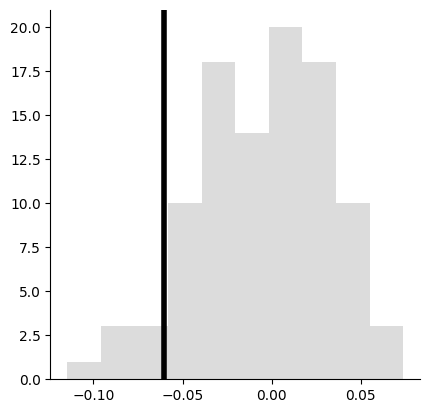

In [26]:
print(f'z-stat:{s1_s2_avg_delta:.2f}')
print(f'p-value:{p_s1_s2}')

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

plt.hist(s1_s2_null_avg_delta_dis, color='gainsboro')
plt.axvline(x=s1_s2_avg_delta,color='k', linewidth=4)
# plt.title('S2 (northwest) - S1 (southeast)')
# plt.xlabel('Average Difference in X Position Decodes')

x0,x1 = plt.gca().get_xlim()
y0,y1 = plt.gca().get_ylim()

plt.gca().set_aspect(abs(x1-x0)/abs(y1-y0))

# plt.legend()

plt.savefig('x_perm_s12.eps', format='eps', bbox_inches='tight')

In [27]:
#t-test for faster evaluation
ttest_rel(s2_preds, s1_preds)

TtestResult(statistic=-3.442255876456861, pvalue=0.0013908493753139984, df=39)

In [22]:
#t-test
ttest_rel(s4_preds,pos)

TtestResult(statistic=-1.4489698661607153, pvalue=0.1553395287882391, df=39)

In [23]:
ttest_rel(s3_preds,pos)

TtestResult(statistic=-4.899803621793944, pvalue=1.717313107157717e-05, df=39)

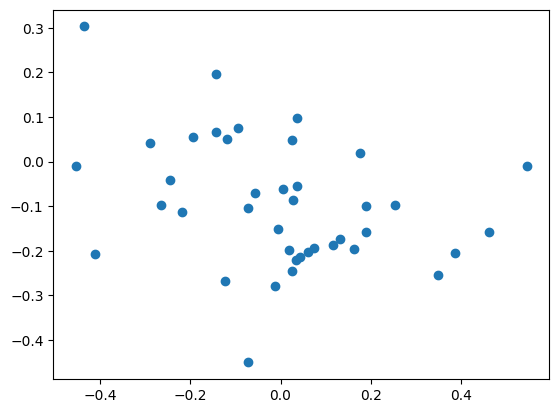

In [19]:
plt.scatter(pos-s5_preds, s4_preds)

In [28]:
# S3 vs S4 null (no double dipping)
s3_s4_null_avg_delta_dis = np.empty(n_runs)
null_s3 = np.empty((n_images,n_neurons))
null_s4 = np.empty((n_images,n_neurons))
for r in range(n_runs):
    np.random.seed(r)
    shuffle_index = np.random.choice(n_neurons, size=n_neurons, replace=False)
    null_s3[:,shuffle_index[0:int(n_neurons/2)]] = s3_neural_for_preds[:,shuffle_index[0:int(n_neurons/2)]]
    null_s4[:,shuffle_index[int(n_neurons/2):int(n_neurons)]] = s3_neural_for_preds[:,shuffle_index[int(n_neurons/2):int(n_neurons)]]
    null_s4[:,shuffle_index[0:int(n_neurons/2)]] = s4_neural_for_preds[:,shuffle_index[0:int(n_neurons/2)]]
    null_s3[:,shuffle_index[int(n_neurons/2):int(n_neurons)]] = s4_neural_for_preds[:,shuffle_index[int(n_neurons/2):int(n_neurons)]]
    delta_store = np.empty((n_images,n_reps))
    for x in range(n_reps):
        for i in range(n_folds):
            train, test = regression_indices(len(pos), number_of_groups=n_folds, test_group= i, SEED= x)
            y_pred_null_s3 = s5_regressors[f"reg_{x}_{i}"].predict(null_s3[test,:])
            y_pred_null_s4 = s5_regressors[f"reg_{x}_{i}"].predict(null_s4[test,:])
            delta_store[test,x]= np.nanmean(y_pred_null_s4 - y_pred_null_s3)
    s3_s4_null_avg_delta_dis[r]= np.nanmean(np.nanmean(delta_store,axis=1))

In [29]:
# comparing S3 and S4 predictions
s3_s4_avg_delta = np.nanmean(s4_preds-s3_preds)
s3_s4_std = np.nanstd(s4_preds-s3_preds)
if s3_s4_avg_delta > 0:
    p_s3_s4 = np.nanmean(s3_s4_null_avg_delta_dis > s3_s4_avg_delta)
else:
    p_s3_s4 = np.nanmean(s3_s4_null_avg_delta_dis < s3_s4_avg_delta)


In [21]:
s3_s4_avg_delta = np.nanmean(s4_preds-s3_preds)
s3_s4_std = np.nanstd(s4_preds-s3_preds)

In [23]:
s3_s4_avg_delta

0.12551685421441502

In [22]:
s3_s4_std

0.1264827635700762

z-stat:0.13
p-value:0.0
sd: 0.13


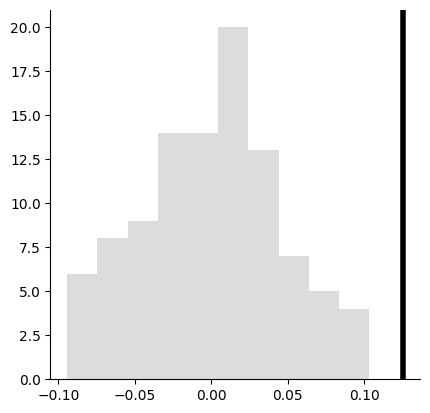

In [30]:
print(f'z-stat:{s3_s4_avg_delta:.2f}')
print(f'p-value:{p_s3_s4}')
print(f'sd: {s3_s4_std:.2f}')

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)


plt.hist(s3_s4_null_avg_delta_dis, color='gainsboro')
plt.axvline(x=s3_s4_avg_delta,color='k', linewidth=4)
# plt.title('S4 (west) - S3 (east)')
# plt.xlabel('Average Difference in X Position Decodes')

x0,x1 = plt.gca().get_xlim()
y0,y1 = plt.gca().get_ylim()

plt.gca().set_aspect(abs(x1-x0)/abs(y1-y0))

# plt.legend()

# plt.savefig('x_perm_s34.eps', format='eps', bbox_inches='tight')


In [38]:
np.mean(s3_preds)

-0.22161103107088928

In [39]:
np.std(s3_preds)

0.12509660645515372

In [40]:
np.mean(s4_preds)

-0.09609417685647423

In [41]:
np.std(s4_preds)

0.1424874314063515

In [42]:
s4_pred_array.shape

(40, 36)

In [43]:
# examining the deltas and t-test results across iterations 
results = []
for x in range(n_reps):
    avg_delta = np.nanmean(s4_pred_array[:,x]-s3_pred_array[:,x]) # calculate the avg delta for each iteration
    test_res = ttest_rel(s4_pred_array[:,x], s3_pred_array[:,x])
    results.append({'delta': avg_delta, 't-stat': test_res.statistic, 'p-value': test_res.pvalue})
df_results = pd.DataFrame(results)
print(df_results)

       delta    t-stat       p-value
0   0.112629  4.902983  1.700223e-05
1   0.115918  5.550516  2.179115e-06
2   0.122191  5.434227  3.157624e-06
3   0.121837  4.858055  1.958110e-05
4   0.130354  5.215680  6.327950e-06
5   0.132484  5.969800  5.704153e-07
6   0.135540  5.535764  2.284166e-06
7   0.108356  5.028832  1.143449e-05
8   0.131104  5.946074  6.153943e-07
9   0.126984  4.995224  1.271436e-05
10  0.130381  5.355129  4.062248e-06
11  0.126966  5.268238  5.355209e-06
12  0.117203  5.008785  1.218170e-05
13  0.144226  6.653819  6.423992e-08
14  0.121080  4.959057  1.425036e-05
15  0.131658  5.503964  2.528087e-06
16  0.116092  4.941285  1.507108e-05
17  0.115535  5.168251  7.355349e-06
18  0.128341  6.353521  1.672897e-07
19  0.124901  4.765418  2.618017e-05
20  0.112817  5.320179  4.540057e-06
21  0.141639  5.469282  2.823772e-06
22  0.105578  4.937198  1.526636e-05
23  0.126786  6.305899  1.947669e-07
24  0.135975  5.312652  4.650068e-06
25  0.131684  5.324877  4.472729e-06
2

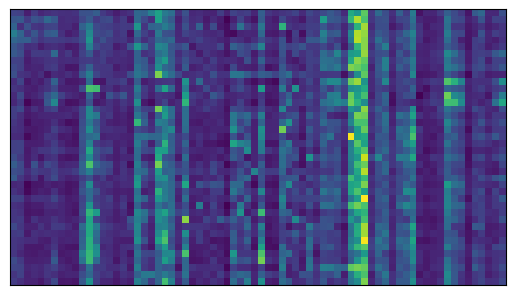

In [44]:
# mapping the responses for each image and each neuron S5
plt.imshow(s5_neural_for_preds, cmap='viridis', interpolation='nearest')
plt.xticks([])
plt.yticks([])
plt.savefig('s5_resp.eps', format='eps', bbox_inches='tight')

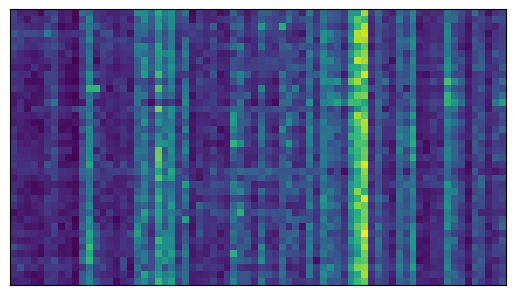

In [45]:
# mapping the responses for each image and each neuron S5
plt.imshow(s4_neural_for_preds, cmap='viridis', interpolation='nearest')
plt.xticks([])
plt.yticks([])
plt.savefig('s4_resp.eps', format='eps', bbox_inches='tight')